# [DRAFT] Dirichlet problem on a circle.

## TODO:

* Based on mms_circle
* Deal with the homogeneous solution.
* Add back in the body force.
* The remaining fundamental issue is the singularity in the volume integral. Set up a way of testing the accuracy of this integral.

## Setup

## Direct to surface eval

For the Poisson equation with Dirichlet boundary conditions:
\begin{split}
\nabla u &= f  ~~ \textrm{in} ~~ \Omega\\
u &= g ~~ \textrm{on} ~~ \partial \Omega
\end{split}
`u_body_force` is the integral:

\begin{equation}
v(x) = \int_{\Omega} G(x,y) f(y) dy
\end{equation}

which satisfies equation 1 but not 2.

Then, compute homogeneous solution with appropriate boundary conditions:

\begin{split}
\nabla u^H &= 0 ~~ \textrm{in} ~~ \Omega \\
u^H &= g - v|_{\partial \Omega}  ~~ \textrm{on} ~~ \partial \Omega
\end{split}

So, first, I need to compute $g - v|_{\partial \Omega}$

In [1]:
from tectosaur2.nb_config import setup

setup()


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

from tectosaur2 import integrate_term, refine_surfaces, gauss_rule
from tectosaur2.laplace2d import double_layer

In [3]:
nq = 10
qx, qw = gauss_rule(nq)

t = sp.symbols("t")
theta = sp.pi * (t + 1)
circle = refine_surfaces([(t, sp.cos(theta), sp.sin(theta))], (qx,qw))
circle.n_pts, circle.n_panels

(320, 32)

In [4]:
## This is g
def soln_fnc(x, y):
    return 2 + x + y

bcs = soln_fnc(circle.pts[:, 0], circle.pts[:, 1])

In [5]:
A,report = integrate_term(double_layer, circle.pts, circle, limit_direction=-1.0, return_report=True)

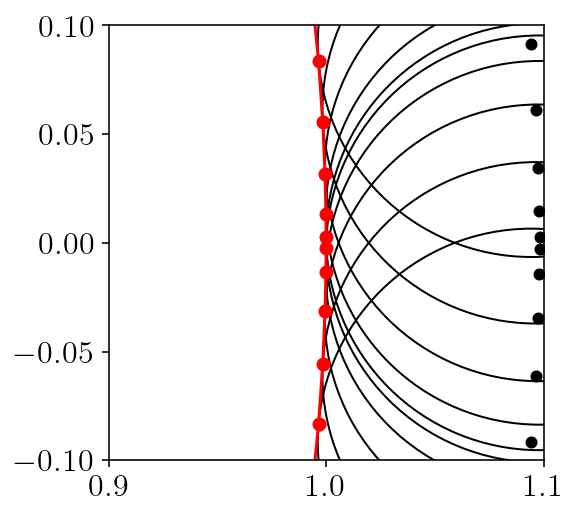

In [6]:

from tectosaur2.debug import plot_centers
plot_centers(report, [0.9, 1.1], [-0.1, 0.1])

In [7]:
surf_density = np.linalg.solve(np.eye(A.shape[0]) + A[:,0,:,0], bcs)

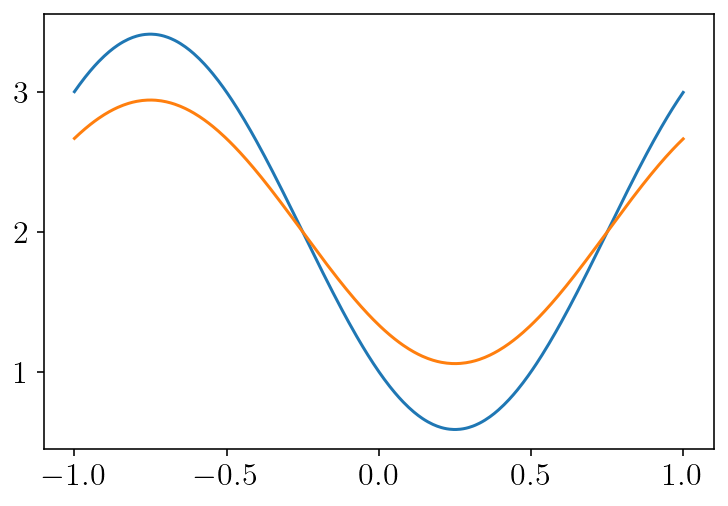

In [8]:
plt.plot(circle.quad_pts, bcs)
plt.plot(circle.quad_pts, surf_density)
plt.show()

In [24]:
nobs = 300
offset = -0.1
zoomx = [-1.0 + offset, 1.0 - offset]
zoomy = [-1.0 + offset, 1.0 - offset]
xs = np.linspace(*zoomx, nobs)
ys = np.linspace(*zoomy, nobs)
obsx, obsy = np.meshgrid(xs, ys)
obs2d = np.array([obsx.flatten(), obsy.flatten()]).T.copy()
obs2d_mask = np.sqrt(obs2d[:, 0] ** 2 + obs2d[:, 1] ** 2) <= 1
obs2d_mask_sq = obs2d_mask.reshape(obsx.shape)
obs2d_mask_away = np.sqrt(obs2d[:, 0] ** 2 + obs2d[:, 1] ** 2) <= 0.9
obs2d_mask_away_sq = obs2d_mask_away.reshape(obsx.shape)
correct = soln_fnc(obsx, obsy)

In [25]:
from tectosaur2.laplace2d import DoubleLayer

In [26]:
%%time
interior_disp_mat = integrate_term(DoubleLayer(d_cutoff=4.0, d_up=2.0, d_qbx=0.4), obs2d, circle, tol=1e-13)

CPU times: user 2.32 s, sys: 480 ms, total: 2.8 s
Wall time: 820 ms


/Users/tbent/Dropbox/active/eq/tectosaur2/tectosaur2/integrate.py:197: UserWarning: Some expanded integrals reached maximum expansion order. These integrals may be inaccurate.
  "Some expanded integrals reached maximum expansion order."


In [27]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [29]:
%lprun -f integrate_term integrate_term(DoubleLayer(d_cutoff=4.0, d_up=2.0, d_qbx=0.4), obs2d, circle, tol=1e-13)

/Users/tbent/Dropbox/active/eq/tectosaur2/tectosaur2/integrate.py:198: UserWarning: Some expanded integrals reached maximum expansion order. These integrals may be inaccurate.
  "Some expanded integrals reached maximum expansion order."


Timer unit: 1e-06 s

Total time: 0.77873 s
File: /Users/tbent/Dropbox/active/eq/tectosaur2/tectosaur2/integrate.py
Function: integrate_term at line 28

Line #      Hits         Time  Per Hit   % Time  Line Contents
    28                                           def integrate_term(
    29                                               K,
    30                                               obs_pts,
    31                                               *srcs,
    32                                               limit_direction=1.0,
    33                                               tol=None,
    34                                               singularities=None,
    35                                               safety_mode=False,
    36                                               return_report=False
    37                                           ):
    38         1          2.0      2.0      0.0      obs_pts = np.asarray(obs_pts, dtype=np.float64)
    39         1          2.0 

In [14]:
u_soln = interior_disp_mat[:, 0, :, 0].dot(surf_density).reshape(obsx.shape)

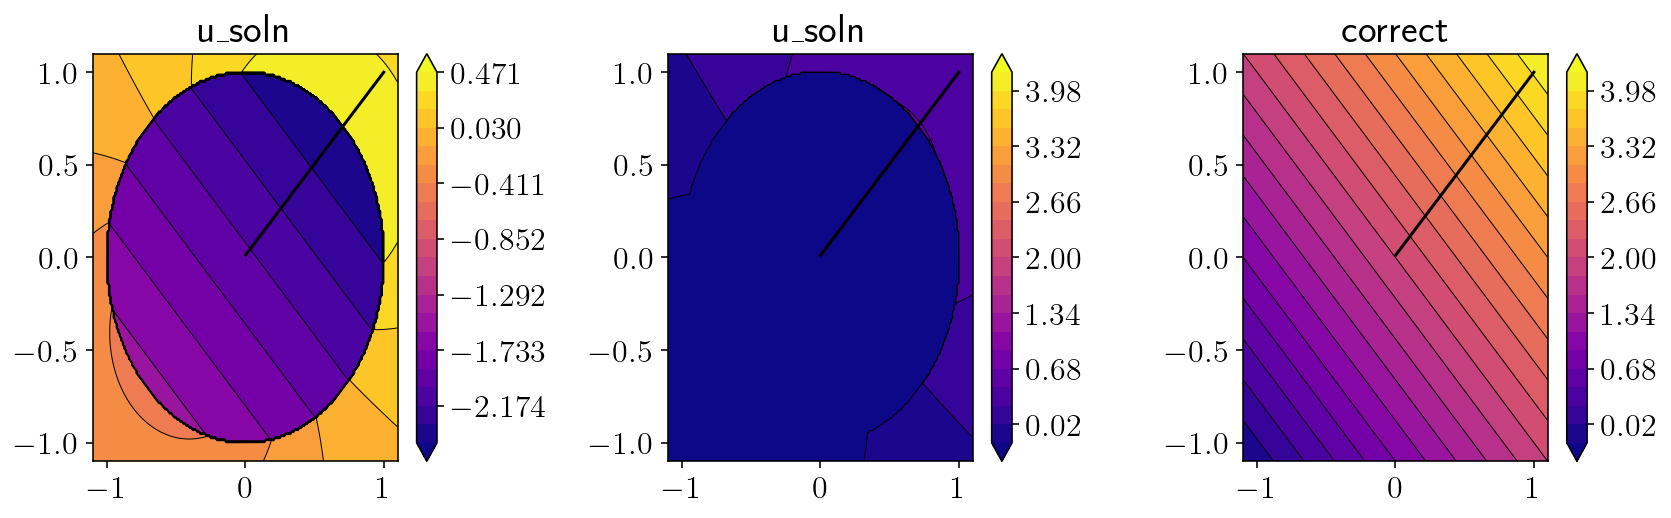

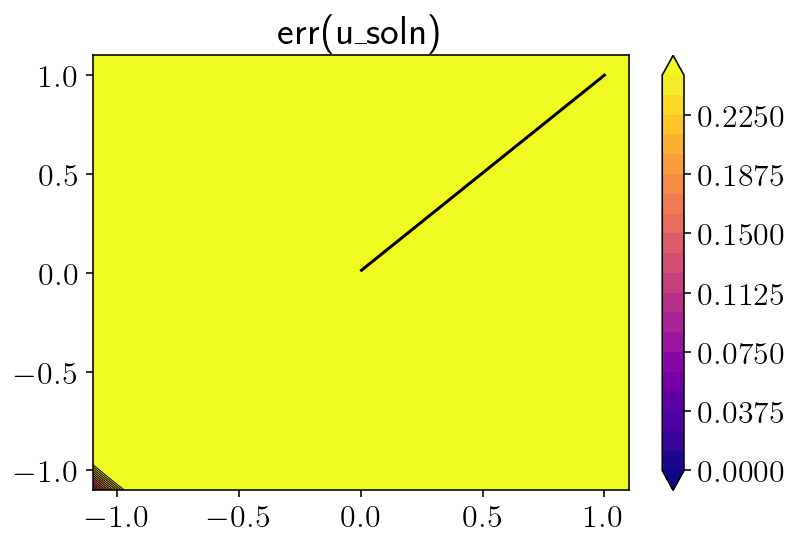

In [15]:
plt.figure(figsize=(12, 4))
for i, to_plot in enumerate([u_soln, u_soln, correct]):
    plt.subplot(1, 3, 1 + i)
    if i == 0:
        levels = np.linspace(np.min(to_plot), np.max(to_plot), 21)
    else:
        cmin = np.min(correct)
        cmax = np.max(correct)
        if cmin == cmax:
            cmin = 0.9 * cmin
            cmax = 1.1 * cmax
        levels = np.linspace(cmin, cmax, 21)

    cntf = plt.contourf(obsx, obsy, to_plot, levels=levels, extend="both")
    plt.contour(
        obsx,
        obsy,
        to_plot,
        colors="k",
        linestyles="-",
        linewidths=0.5,
        levels=levels,
        extend="both",
    )
    plt.plot(circle.pts[0], circle.pts[1], "k-", linewidth=1.5)
    plt.colorbar(cntf)
    plt.xlim(zoomx)
    plt.ylim(zoomy)
    plt.title(["u\_soln", "u\_soln", "correct"][i])
plt.tight_layout()

plt.figure()
to_plot = np.abs(correct - u_soln)
levels = np.linspace(0, 0.25, 21)
cntf = plt.contourf(obsx, obsy, to_plot, levels=levels, extend="both")
plt.contour(
    obsx,
    obsy,
    to_plot,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=levels,
    extend="both",
)
plt.plot(circle.pts[0], circle.pts[1], "k-", linewidth=1.5)
plt.colorbar(cntf)
plt.xlim(zoomx)
plt.ylim(zoomy)
plt.title("err(u\_soln)")
plt.show()